Jupyter notebook used for doing exploratory data analysis and data prep on the raw Epsilon data created by the separate "Personal Data Datasets - camelot_pdf_reads.ipynb" notebook

Note that some topic modelling using a NMF model is also done later in this notebook

In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline

import nltk
import gensim
import spacy

In [4]:
# load dataframe created by the Camelot pdf extraction notebook
all_recs = pd.read_pickle('path to pickle format Epsilon df')

In [ ]:
all_recs

In [6]:
len(all_recs)

3199

In [ ]:
# prep steps

In [7]:
all_recs.fillna('',inplace=True)

In [8]:
all_recs.reset_index(drop=True, inplace=True)

In [ ]:
all_recs

In [ ]:
# Epsilon's data was spread across several tables within the pdf file. The pdf table extraction process combines all records
# from all tables into one large dataframe
# I prepared the notes below in order to know which records to take from the combined file for my analysis of the
# inference records (labelled "PERSONAL DATA - Inferred Household Characteristics..." below)
# As shown below, those records were at index values 646 - 3,198 in the combined df

##### del index values 0-13 - initial descriptive material
# THIRD PARTIES TO WHOM EPSILON SHARES PERSONAL DATA - index values 14-47
# THIRD PARTIES TO WHOM EPSILON SELLS PERSONAL DATA Categories of third parties to whom personal data is sold - 50 - 72**SEPARATE ON \n** BUT NOTE - SOME \n may be valid, within a single category
# PARtIES TO WHOM EPSILON DISCLOSES PERSONAL DATA FOR A BUSINESS PURPOSE - 80-81
# PERSONAL DATA - Specific pieces of personal data collected and derived, and used to create consumer profiles: 82 - 157
# PERSONAL DATA - Activities and Interests sub-category - NOT IN DATAFRAME - two rows: "Mail Order Buyer" and "Political Affilition", with no values assigned to these features
# PERSONAL DATA - Transactions - Generalized purchase data sub-category - 160 - 221
# PERSONAL DATA - Transaction summary - 224 - 233
# PERSONAL DATA - Online Activity - Generalized online browsing activity - 234 - 598
# PERSONAL DATA - Consumer and Household Characteristics - 599 - 624
# PERSONAL DATA - Vehicle Ownership - 625 - 628
# PERSONAL DATA - Credit Card Types - missing from dataframe - one row - "Estimated Number of Credit Cards" - with an incorrect value of 0
# PERSONAL DATA - Property Ownership - Specific pieces of personal data collected and derived to describe property owned - 629 - 645

# PERSONAL DATA - Inferred Household Characteristics - Epsilon collects data inferred by third parties, and derives data elements using Epsilon proprietary methods - 646 - 766
# PERSONAL DATA - Inferred Household Characteristics - ZIP Code - Epsilon collects data that describes characteristics of many households in a specific geographic area. Epsilon derives additional descriptors for a geography and assigns both collected and inferred characteristics to individual households - 767 - 2318
# PERSONAL DATA - Inferred Household Characteristics - Neighborhood ZIP Code - Epsilon collects data that describes characteristics of many households in a specific geographic area. Epsilon derives additional descriptors for a geography and assigns both collected and inferred characteristics to individual households - 2319 - 3198

In [24]:
# For interest value, I show below the "THIRD PARTIES TO WHOM EPSILON SHARES PERSONAL DATA"
# I do not use this data in the topic analysis, as I chose to use only the "inferences" data from each vendor
all_recs.loc[14:47]

,0,1,2,3,4,5,6,7,8,9,10,11,12
14,Advertising Networks,,,,,,,,,,,,
15,Advertising/Marketing Companies,,,,,,,,,,,,
16,Affiliates not under the Epsilon brand,,,,,,,,,,,,
17,Apparel & Accessory Companies,,,,,,,,,,,,
18,Automotive Companies,,,,,,,,,,,,
19,Business Services/Agencies,,,,,,,,,,,,
20,Business to Business Companies,,,,,,,,,,,,
21,Communication Services Companies,,,,,,,,,,,,
22,Consumer Data Resellers,,,,,,,,,,,,
23,Consumer Packaged Goods Companies,,,,,,,,,,,,


In [ ]:
# START HERE WITH INFERENCES ANALYSIS

In [182]:
pdata_inf_hshld_charac = all_recs.loc[646:766]

In [ ]:
pdata_inf_hshld_charac

In [184]:
pdata_inf_hshld_charac = pdata_inf_hshld_charac.loc[:, 0:1] # drop unused columns carried over from the combined df

In [ ]:
pdata_inf_hshld_charac

In [187]:
len(pdata_inf_hshld_charac)

121

household inferences focused mostly on financial measures, including income, wealth, credit, purchasing patterns,  and value of homes and cars owned

In [ ]:
# Now look at the largest inferences category -- characteristics at the "zip" high level category

In [188]:
pdata_inf_zip_charac_det = all_recs.loc[767:2318]

In [ ]:
pdata_inf_zip_charac_det

In [190]:
pdata_inf_zip_charac_det = pdata_inf_zip_charac_det.loc[:, 0:1] # drop unused columns carried over from the combined df

In [ ]:
pdata_inf_zip_charac_det

In [192]:
len(pdata_inf_zip_charac_det)

1552

In [21]:
# some detail rows have newline characters, resulting in blank rows
# replace the newline characters, delete the blank rows,
# and continue the analysis of the subset of records
# related to activity, average, percent and total

In [193]:
pdata_inf_zip_charac_det[1] = pdata_inf_zip_charac_det[1].str.replace(' \n', '')

In [194]:
pdata_inf_zip_charac_det.drop([852, 1104, 1566, 1646], inplace=True)

In [195]:
splitdf = pdata_inf_zip_charac_det[0].str.split(n=2, expand=True)

In [196]:
splitdf[[0, 1]].value_counts()

0       1          
Census  Block          251
        Tract          249
        ZIP            248
Zip2    Percent        200
Zip     Percent        200
Zip2    Level          124
ZIP     Level          124
Zip     Average         46
Zip2    Average         46
        Seasonality      4
Zip     Seasonality      4
        Activity         4
Zip2    Activity         4
        Total            3
Zip     Channel          3
Zip2    Channel          3
Zip     Total            3
        Longitude        2
        Latitude         2
Zip2    Zip              2
        Latitude         2
        Longitude        2
        Match            1
        Market           1
        Occupation       1
        Nielsen          1
        Standard         1
        ZIP              1
        ZIP+2            1
        Property         1
Zip     ZIP              1
Zip2    FIPS             1
        Demographic      1
Zip     Standard         1
        Property         1
        Occupation       1
        

In [25]:
pd.DataFrame(splitdf[[0, 1]].value_counts()).reset_index()

,0,1,count
0,Census,Block,251
1,Census,Tract,249
2,Census,ZIP,248
3,Zip2,Percent,200
4,Zip,Percent,200
5,Zip2,Level,124
6,ZIP,Level,124
7,Zip,Average,46
8,Zip2,Average,46
9,Zip2,Seasonality,4


748 of the 1,548 or 48% detail characteristics inferences start with the word "Census" followed by "Block", "Tract" or "ZIP". The remainder start with "Zip" or "Zip2". My initial reaction was to assume that the inferences starting with "Zip" or "Zip2" were actually breakdowns of the "Census ZIP" inferences. However, the "Census Zip" inferences cover different types of measurements than those in the "Zip" or "Zip2" high level categories. Perhaps the "Census" inferences actually refer to the source of the underlying daya -- coming from US Census Bureau sources, versus the "Zip" and "Zip2" inferences that may come from other sources of geography-based data.  

In [72]:
splitdf.to_pickle('Epsilon/splitdf.pkl')

In [ ]:
# let's look at the "Zip" and "Zip2" inferences

In [56]:
# The vast majority of the Zip/Zip2 inferences are shown with aggregations  
# of 'Average', 'Level', or 'Percent'
splitdf.loc[splitdf[1].str.contains('Average|Level|Percent', regex=True)]

,0,1,2
1271,Zip,Percent,of households owning a registered vehicle
1272,Zip,Percent,of households owning a registered New vehicle
1273,Zip,Percent,of households owning a registered Used vehicle
1274,Zip,Percent,of households owning a registered Passenger Car
1275,Zip,Percent,of households owning a registered new Passenger Car
1276,Zip,Percent,of households owning a registered used Passenger Car
1277,Zip,Percent,of households owning a registered Truck
1278,Zip,Percent,of households owning a registered new Truck
1279,Zip,Percent,of households owning a registered used Truck
1280,Zip,Percent,of households owning a registered Motorcycle


In [57]:
splitdf_2 = splitdf[[1,2,0]].loc[splitdf[1].str.contains(
    'Average|Level|Percent', regex=True)].sort_values(
    [1,2,0])

In [58]:
splitdf_2.columns = ['Inference Unit of Measure', 'Inference Type', 'Geographic Level']

In [59]:
splitdf_2

,Inference Unit of Measure,Inference Type,Geographic Level
2243,Average,- number of sources,Zip
1304,Average,CMV in thousands for New Registered Cars,Zip
1766,Average,CMV in thousands for New Registered Cars,Zip2
1303,Average,CMV in thousands for New and Used Registered Cars,Zip
1765,Average,CMV in thousands for New and Used Registered Cars,Zip2
1305,Average,CMV in thousands for Used Registered Cars,Zip
1767,Average,CMV in thousands for Used Registered Cars,Zip2
1301,Average,CMV in thousands for all New Registered Vehicles,Zip
1763,Average,CMV in thousands for all New Registered Vehicles,Zip2
1359,Average,CMV in thousands for all New Registered Vehicles 0-1 Years Old,Zip


In [60]:
splitdf_2['Inference Type'].value_counts()

Inference Type
Length of Residence more than 10 years                                      2
of households owning a registered new Truck                                 2
of households owning a registered vehicle 4-5 years old                     2
of households owning a registered vehicle 21+ years old                     2
of households owning a registered vehicle 2-3 years old                     2
of households owning a registered vehicle 16-20 years old                   2
of households owning a registered vehicle 11-15 years old                   2
of households owning a registered vehicle 0-1 year old                      2
of households owning a registered vehicle                                   2
of households owning a registered used Truck                                2
of households owning a registered used Passenger Car                        2
of households owning a registered new Passenger Car                         2
of households owning a registered Propane Vehicle

In [61]:
len(splitdf_2['Inference Type'].value_counts())

372

In [65]:
splitdf_2.to_pickle('Epsilon/splitdf_2.pkl')

In [ ]:
# the above section covers all the "Zip" high-level category records except those few Zip/Zip2 records that 
# are not aggregated at percent, average, or level with Zip or Zip2 

In [ ]:
# for topic analysis, use splitfd[2], and replace CMV with Current Market Value, and drop duplicates -- this way,
# all inferences in the "Zip" and "Census" high-level categories will be included

In [ ]:
# now let's take a look at the types of inferences in the"Census" high-level category

In [44]:
# examine the features that start with 'Census'
splitdf_3 = splitdf[[0,1,2]].loc[splitdf[0].str.contains(
    'Census', regex=True)].sort_values(
    [0,1,2])

In [45]:
splitdf_3

,0,1,2
1025,Census,Block,Area Latitude
1026,Census,Block,Area Longitude
1022,Census,Block,Block Group Number
1023,Census,Block,CBSA Code
1018,Census,Block,Census County code
1017,Census,Block,Census Standard State Code
1020,Census,Block,Census Tract
1021,Census,Block,Census Tract Suffix
1024,Census,Block,DMA Code
1081,Census,Block,Families: Percent 2-person Family household


In [46]:
splitdf_3.columns = ['Category', 'Census Geographic Level', 'Inference Type']

In [47]:
splitdf_3

,Category,Census Geographic Level,Inference Type
1025,Census,Block,Area Latitude
1026,Census,Block,Area Longitude
1022,Census,Block,Block Group Number
1023,Census,Block,CBSA Code
1018,Census,Block,Census County code
1017,Census,Block,Census Standard State Code
1020,Census,Block,Census Tract
1021,Census,Block,Census Tract Suffix
1024,Census,Block,DMA Code
1081,Census,Block,Families: Percent 2-person Family household


In [48]:
pd.DataFrame(splitdf_3['Inference Type'].value_counts())

,count
Inference Type,
Area Latitude,3
Population 16+ Employed Civilian: Percent Self-Employed Worker,3
Population 16+ Male in Labor Force: Percent Labor Force Unemployed Male,3
Population 16+: Percent Armed Forces,3
Population 16+: Percent Females in Labor Force,3
Population 16+: Percent Males in Labor Force,3
Population 16+: Percent in Labor Force,3
Population 25+: Average School Years Completed,3
Population 25+: Median School Years Completed,3


In [49]:
len(splitdf_3)

748

In [50]:
splitdf_3.value_counts(['Census Geographic Level'])

Census Geographic Level
Block                      251
Tract                      249
ZIP                        248
Name: count, dtype: int64

US Census Bureau data is broken down at multiple levels. Here we see the census data at Block, Tract, and Zip levels. Census Blocks are divided into census tracts. Zips are not sub- nor supersets of block or tracts, but rather are a different geographic dimension determined by the US Post Office.

Of the 748 inferences in the Census category, all are shown at the Block, Tract or Zip levels.

In [52]:
splitdf_3.to_pickle('Epsilon/splitdf_3.pkl')

In [53]:
splitdf_3 = pd.read_pickle('Epsilon/splitdf_3.pkl')

In [67]:
# what are the vehicle-related features?
pdata_inf_zip_charac_det.loc[pdata_inf_zip_charac_det[0].str.contains(
    ' car| auto|vehicle|truck| SUV|motorcycle|midsize|compact|subcompact|fullsize|pickup|domestic|import|camper|motor home',
    regex=True)]

,0,1
1271,Zip Percent of households owning a registered vehicle,079.98
1272,Zip Percent of households owning a registered New vehicle,060.93
1273,Zip Percent of households owning a registered Used vehicle,050.21
1281,Zip Percent of households with females that own a registered vehicle,039.70
1282,Zip Percent of households owning 1 registered vehicle,019.41
1283,Zip Percent of households owning 2 registered vehicles,019.96
1284,Zip Percent of households owning 3 registered vehicles,015.41
1285,Zip Percent of households owning 4 registered vehicles,010.91
1286,Zip Percent of households owning 5 registered vehicles,006.53
1287,Zip Percent of households that own more than 1 vehicle,060.57


In [68]:
len(pdata_inf_zip_charac_det.loc[pdata_inf_zip_charac_det[0].str.contains(
    ' car| auto|vehicle|truck| SUV|motorcycle|midsize|compact|subcompact|fullsize|pickup|domestic|import|camper|motor home',
    regex=True)])

226

In [197]:
# create the list of Zip/Census inference types to be added to the combined list of inference types
# to be used in topic analysis
# "CMV" appears in a lot of the Zip/Census inferences -- replace it with "Current Market Value"
tseries_zip_census = splitdf[2]
tseries_zip_census = tseries_zip_census.str.replace('CMV', 'Current Market Value')
tseries_zip_census

767                                                                                                                                                Level Code
768                                                                                                                                Census Standard State Code
769                                                                                                                                        Census County code
770                                                                                                                                                  ZIP Code
771                                                                                                                                                 CBSA Code
772                                                                                                                                                  DMA Code
773                                                 

In [198]:
len(tseries_zip_census)

1548

In [ ]:
# now, examine the "neighborhood" data
# it is not clear how "neighborhood" is defined, but it appears to be another geographic view of data
# the data topics are different than those in the Census/Zip/Zip2 group??
# Note that the term "trades" is introduced in this set of records
# "trades" relates to credit card related activity - new cards, card transactions, etc.

In [199]:
pdata_inf_neighborhood_zip = all_recs.loc[2319:3198]

In [200]:
pdata_inf_neighborhood_zip

,0,1,2,3,4,5,6,7,8,9,10,11,12
2319,Aggregated current balance of all collections,44.64,,,,,,,,,,,
2320,Average age of adults in neighborhood,42.36,,,,,,,,,,,
2321,Age in months of most recent inquiry,188.73,,,,,,,,,,,
2322,Number of trades,9.18,,,,,,,,,,,
2323,Number of currently active trades,3.18,,,,,,,,,,,
2324,Number of satisfactory trades,4.82,,,,,,,,,,,
2325,Number of trades opened in past 3 months,0.00,,,,,,,,,,,
2326,Number of trades opened in past 6 months,0.09,,,,,,,,,,,
2327,Number of trades opened in past 12 months,0.73,,,,,,,,,,,
2328,Number of trades opened in past 24 months,1.64,,,,,,,,,,,


In [201]:
pdata_inf_neighborhood_zip.loc[~(pdata_inf_neighborhood_zip[2] == '')]

,0,1,2,3,4,5,6,7,8,9,10,11,12


In [202]:
pdata_inf_neighborhood_zip = pdata_inf_neighborhood_zip.loc[:, 0:1] # drop unused columns

In [203]:
pdata_inf_neighborhood_zip

,0,1
2319,Aggregated current balance of all collections,44.64
2320,Average age of adults in neighborhood,42.36
2321,Age in months of most recent inquiry,188.73
2322,Number of trades,9.18
2323,Number of currently active trades,3.18
2324,Number of satisfactory trades,4.82
2325,Number of trades opened in past 3 months,0.00
2326,Number of trades opened in past 6 months,0.09
2327,Number of trades opened in past 12 months,0.73
2328,Number of trades opened in past 24 months,1.64


In [204]:
pdata_inf_neighborhood_zip.loc[pdata_inf_neighborhood_zip[0].str.startswith('AUTO -')]

,0,1
2557,AUTO - Likely to Buy New Vehicle,43
2558,AUTO - Likely to Buy Used Vehicle,9
2559,AUTO - Likely to Buy Domestic Vehicle,10
2560,AUTO - Likely to Buy Import Vehicle,14
2561,AUTO - Likely to Purchase Same Manufacturer,30
2562,AUTO - Likely to Lease Vehicle,16
2563,AUTO - Propensity to Buy Economy Car,10
2564,AUTO - Propensity to Buy Economy SUV,49
2565,AUTO - Propensity to Buy Midsize Car,14
2566,AUTO - Propensity to Buy Midsize SUV,20


In [205]:
len(pdata_inf_neighborhood_zip.loc[pdata_inf_neighborhood_zip[0].str.startswith('AUTO -')])

33

In [ ]:
pdata_inf_neighborhood_zip.loc[pdata_inf_neighborhood_zip[0].str.startswith('MT -')]

In [207]:
len(pdata_inf_neighborhood_zip.loc[pdata_inf_neighborhood_zip[0].str.startswith('MT -')])

600

out of 880 neighborhood inferenecs, 33, preceded with 'AUTO -', relate to the person's likelihood to buy various types of vehicles, how they are likely to purchase one, and the type of vehicle they currently own

600 of the 880, preceded with 'MT -', cover a wide variety of inferences, including such things as sports preferences, shopping method preferences, preferred types of music, financial matters, mobile provider used, travel patterns, fitness preferences, dining out patterns, texhnology adoption profile, preferred retail outlets, brand switching patterns, and charitable contribution patterns. 

The remaining 247 inferenes focus extensively on credit usage patterns in the neighborhood, including things like average number of unique credit accounts per houshold, credit usage patterns, average balances, months delinquent, and bankruptcies

In [ ]:
# use pdata_inf_neighborhood_zip[0] for the topic analysis, deleting any "AUTO -" and "MT -" prefixes, and 
# dropping any duplicate topics (duplicates dropped later, after all inferences are combined)

In [213]:
tseries_neighborhood_inf = pdata_inf_neighborhood_zip[0]

In [214]:
tseries_neighborhood_inf = teries_neighborhood_inf.str.replace('AUTO -', '')

In [215]:
tseries_neighborhood_inf = teries_neighborhood_inf.str.replace('MT -', '')

In [216]:
tseries_neighborhood_inf.loc[teries_neighborhood_inf.str.contains('AUTO')]

Series([], Name: 0, dtype: object)

In [217]:
len(tseries_neighborhood_inf)

880

In [219]:
# create a combined series of all inferences, including household characteristics, zip/census inferences,
# and neighborhood inferences to use in topic analysis
combined_inf = pd.concat([pdata_inf_hshld_charac[0], tseries_zip_census, tseries_neighborhood_inf])

In [221]:
len(combined_inf)

2549

In [222]:
# save the combined inferences, before dropping duplicate inferences and before checking for and dropping
# any null records
combined_inf.to_pickle('Epsilon/combined_inf_with_dups_and_nulls.pkl')

In [5]:
combined_inf = pd.read_pickle('Epsilon/combined_inf_with_dups_and_nulls.pkl')

In [6]:
len(combined_inf.drop_duplicates())

1665

In [7]:
combined_inf = combined_inf.drop_duplicates()

In [8]:
combined_inf.loc[combined_inf.isnull()]

1268    None
dtype: object

In [9]:
combined_inf = combined_inf.loc[~(combined_inf.isnull())]

In [10]:
len(combined_inf)

1664

In [11]:
combined_inf

646                             Agility Address Key
647                           Agility Household Key
648               Agility Individual Key - Person 1
649                         Agility Occupancy Score
650                           Member code of person
                           ...                     
3194                          Miller Lite Switchers
3195                       Online Pharmacy Shoppers
3196        Online Travel Agency Airfare Purchasers
3197                          Pasta Brand Switchers
3198                  Pro Wrestling Wwe Enthusiasts
Length: 1664, dtype: object

In [12]:
# drop digits from the data
combined_inf = combined_inf.str.replace('\d+', '', regex=True)

In [13]:
combined_inf

646                             Agility Address Key
647                           Agility Household Key
648                Agility Individual Key - Person 
649                         Agility Occupancy Score
650                           Member code of person
                           ...                     
3194                          Miller Lite Switchers
3195                       Online Pharmacy Shoppers
3196        Online Travel Agency Airfare Purchasers
3197                          Pasta Brand Switchers
3198                  Pro Wrestling Wwe Enthusiasts
Length: 1664, dtype: object

In [25]:
# use this .csv version for the nmf modelling below
combined_inf.to_csv('Epsilon/combined_inf_no_dups_no_nulls_no_idx.csv', index=False)

In [ ]:
# use the pkl version to backup the data
combined_inf.to_pickle('Epsilon/combined_inf_no_dups_no_nulls_no_idx.pkl')

In [14]:
# read the data back in
combined_inf = pd.read_pickle('Epsilon/combined_inf_no_dups_no_nulls_no_idx.pkl')

In [16]:
combined_inf

646                             Agility Address Key
647                           Agility Household Key
648                Agility Individual Key - Person 
649                         Agility Occupancy Score
650                           Member code of person
                           ...                     
3194                          Miller Lite Switchers
3195                       Online Pharmacy Shoppers
3196        Online Travel Agency Airfare Purchasers
3197                          Pasta Brand Switchers
3198                  Pro Wrestling Wwe Enthusiasts
Length: 1664, dtype: object

In [ ]:
# do topic analysis on all inference records together, including those from the Zip, Census, and Neighborhood
# high-level categories
# Note that duplicate inferences are dropped (in above sections) before the combined list is created

In [6]:
docs = pd.read_csv('Epsilon/combined_inf_no_dups_no_nulls_no_idx.csv')

In [30]:
type(combined_inf)

pandas.core.series.Series

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jeffb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
from nltk.corpus import stopwords

In [19]:
stopwords_list = stopwords.words('english')

In [21]:
from sklearn.feature_extraction.text import CountVectorizer 

In [ ]:
# do topic analysis with nmf as described in https://www.anaconda.com/blog/introduction-to-text-analysis-with-python-in-excel
# some preprocessing steps modelled after https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8

In [20]:
ngram_range = (2,3)
color_spec='c'
if ngram_range[0] == 2:
    ngram_txt_1 = 'Bi-grams'
elif ngram_range[0] == 3:
    ngram_txt_1 = 'Tri-grams'
else:
    ngram_txt_1 = f'{ngram_range[0]}-grams'

if ngram_range[1] == 3:
    ngram_txt_2 = 'Tri-grams'
else:
    ngram_txt_2 = f'{ngram_range[1]}-grams'
    
plot_title_text = 'Inferences\n' + \
                   ngram_txt_1 + ' - ' + ngram_txt_2
print(plot_title_text)

Inferences
Bi-grams - Tri-grams


In [22]:
# Create CountVectorizer object
# CountVectorizer converts a collection of text documents to a matrix of token counts
c_vec = CountVectorizer(stop_words=stopwords_list, ngram_range=ngram_range)
# Fit the CountVectorizer to the reviews data to get a matrix of ngrams
ngrams = c_vec.fit_transform(combined_inf)

In [23]:
ngrams

<1664x4565 sparse matrix of type '<class 'numpy.int64'>'
	with 8963 stored elements in Compressed Sparse Row format>

In [39]:
# Count the frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

In [40]:
# Get a list of ngrams
vocab = c_vec.vocabulary_

In [41]:
vocab

{'agility address': 80,
 'address key': 46,
 'agility address key': 81,
 'agility household': 82,
 'household key': 1563,
 'agility household key': 83,
 'agility individual': 84,
 'individual key': 1684,
 'key person': 1824,
 'agility individual key': 85,
 'individual key person': 1685,
 'agility occupancy': 86,
 'occupancy score': 2513,
 'agility occupancy score': 87,
 'member code': 2173,
 'code person': 734,
 'member code person': 2174,
 'baby boomers': 269,
 'niche switch': 2378,
 'switch date': 4029,
 'niche switch date': 2379,
 'switch new': 4030,
 'new niche': 2351,
 'niche switch new': 2380,
 'switch new niche': 4031,
 'switch type': 4032,
 'niche switch type': 2381,
 'niches code': 2382,
 'verification date': 4413,
 'date household': 899,
 'verification date household': 4414,
 'date person': 900,
 'verification date person': 4415,
 'target income': 4046,
 'income indicator': 1663,
 'target income indicator': 4048,
 'target narrow': 4049,
 'narrow band': 2309,
 'band income': 3

In [42]:
# Create a DataFrame to store the frequency and n-gram, sorted in descending order of frequency
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:ngram_txt_1 + ' - ' + ngram_txt_2})
# Display the top 10 n-grams by frequency
df_ngram.head(n=10) 

,frequency,Bi-grams - Tri-grams
0,143,owning registered
1,143,households owning registered
2,143,households owning
3,62,housing units
4,56,population percent
5,42,occupied housing units
6,42,occupied housing
7,39,households percent
8,38,years old
9,38,units percent


In [43]:
df_ngram.head(50)

,frequency,Bi-grams - Tri-grams
0,143,owning registered
1,143,households owning registered
2,143,households owning
3,62,housing units
4,56,population percent
5,42,occupied housing units
6,42,occupied housing
7,39,households percent
8,38,years old
9,38,units percent


In [ ]:
fname = 'Epsilon/ngram_freq_' + ngram_txt_1 + '_to_' + ngram_txt_2 + '.csv'
fname_plt = 'Epsilon/topic_plot_' + ngram_txt_1 + '_to_' + ngram_txt_2 + '.png'
print(fname)
print(fname_plt)
df_ngram.to_csv(fname, index=False)

C:\Users\jeffb\AppData\Local\Temp\ipykernel_13928\714636315.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, rotation=0)


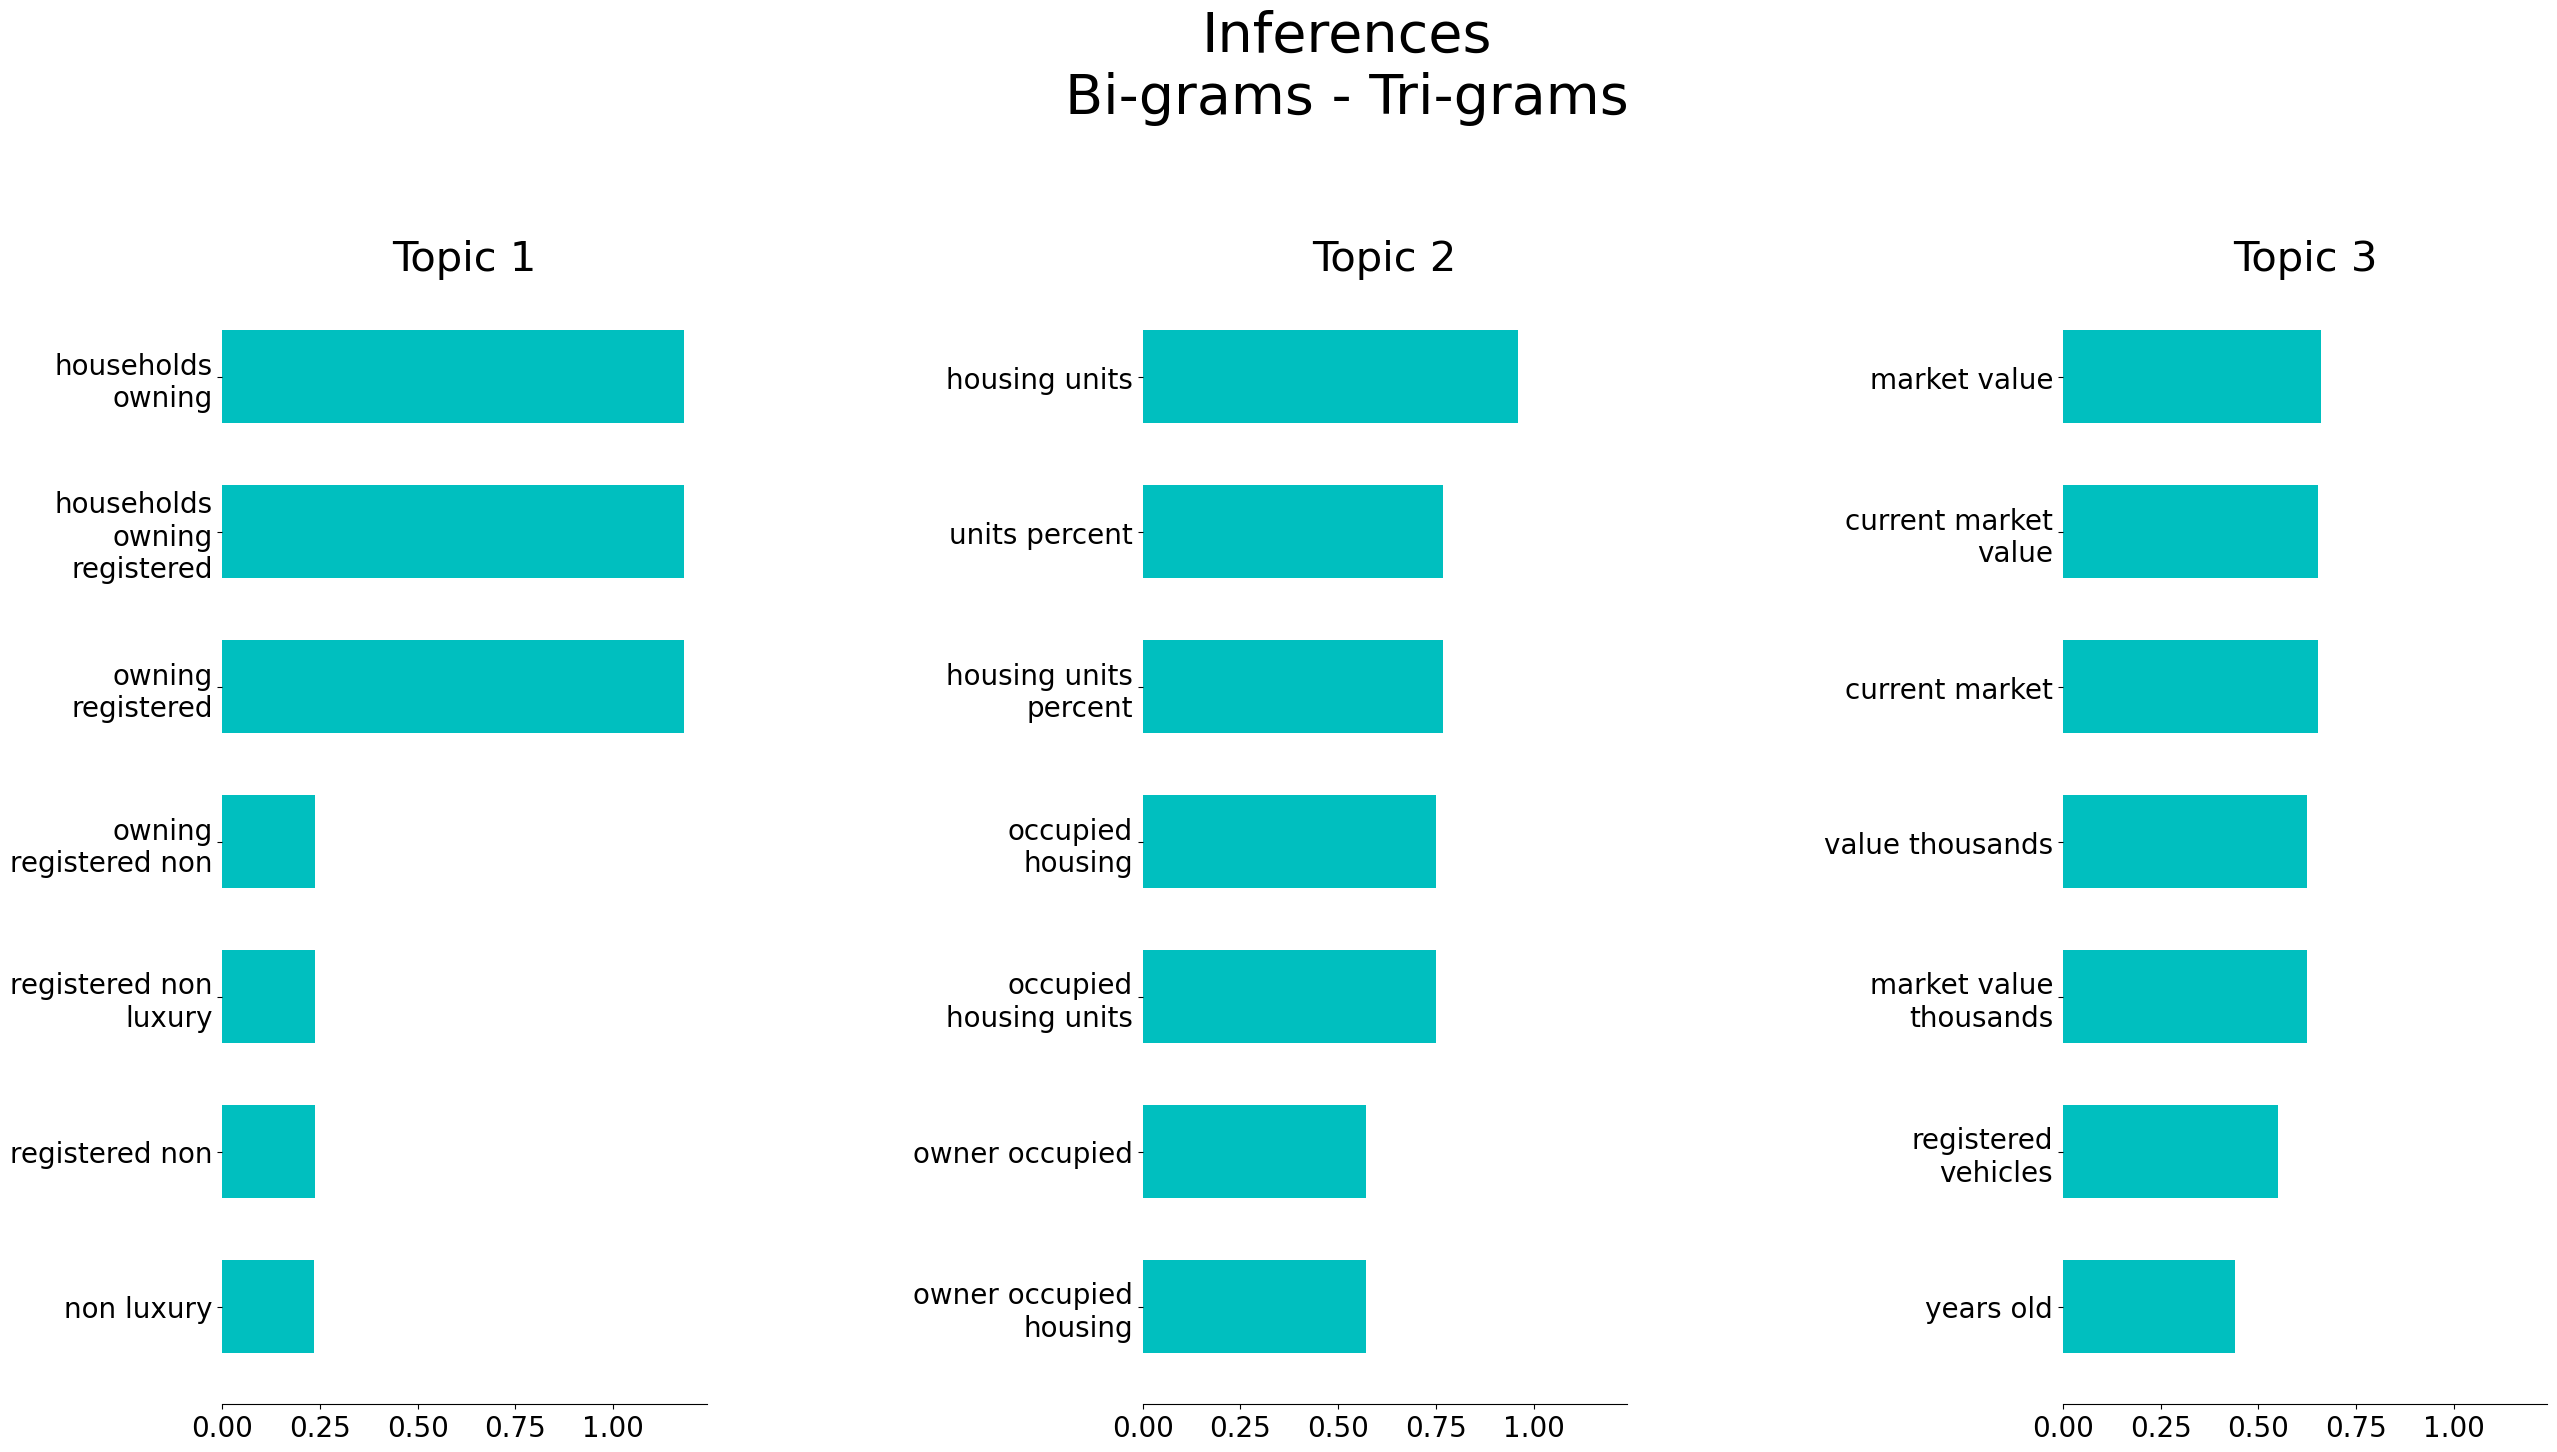

In [32]:
# plot top words

# Create a TF-IDF vectorizer object
# TF-IDF (Term Frequency-Inverse Document Frequency) is a technique used to quantify a word in documents
# It is used to reflect how important a word is to a document in a collection or corpus
# The stop_words parameter is used to ignore common words in English such as 'this', 'is', etc.
# The ngram_range parameter is used to specify the size of word chunks to consider as features
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=ngram_range)

# Create an NMF (Non-Negative Matrix Factorization) object
# The n_components parameter is used to specify the number of topics to extract
nmf = NMF(n_components=3)
# nmf = NMF(n_components=8)

# Create a pipeline object that sequentially applies the TF-IDF vectorizer and NMF
pipe = make_pipeline(tfidf_vectorizer, nmf)

# Fit the pipeline to the reviews data
pipe.fit(combined_inf)

import textwrap

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

def plot_top_words(model, feature_names, n_top_words, title):
    """
    Plot top words in topics 
    source: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """

    # text wrapping pattern from: https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
    
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
#    fig, axes = plt.subplots(3, 3, figsize=(30, 35), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.6, color=color_spec)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        wrap_labels(ax, 15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.8, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(fname_plt, bbox_inches='tight')
    plt.show()

# Plot the top words in the topics identified by the NMF model
plot_top_words(
    nmf, tfidf_vectorizer.get_feature_names_out(), 7, plot_title_text
)

In [47]:
nmf.components_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.76587554e-14, 3.76587554e-14, 1.62635039e-14, ...,
        3.90001666e-08, 3.03203260e-17, 3.03203260e-17],
       [3.04547552e-13, 3.04547552e-13, 1.30495411e-13, ...,
        1.39808183e-05, 2.49854808e-16, 2.49854808e-16]])

In [54]:
def disp_top_words(model, feature_names, n_top_words, ngram_range):
    tmp_rslts_list = []
    for topic_idx, topic in enumerate(model.components_):
        print('topic_idx and topc\n',topic_idx, topic, '\n')
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        print('top_features_ind\n', top_features_ind, '\n')
        top_features = [feature_names[i] for i in top_features_ind]
        print('top_features', top_features, '\n')
        weights = topic[top_features_ind]
        print('weights', weights, '\n')
        print('number of features', len(feature_names), '\n\n\n')
        # num_top_topics, top_topic_num, topic_text, topic_weight
        for i in top_features_ind:
            tmp_rslts_list.append(
                [len(model.components_), topic_idx,
                 feature_names[i], topic[i], ngram_range])
    return tmp_rslts_list


In [60]:
ngram_range = (4,7)

tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=ngram_range)

rslts_list=[] 

n_sub_topics = 10

for n_components in range(3,9):
    nmf = NMF(n_components)

    pipe = make_pipeline(tfidf_vectorizer, nmf)

    pipe.fit(combined_inf)
    t_rslts_list = disp_top_words(
        nmf, tfidf_vectorizer.get_feature_names_out(), n_sub_topics, ngram_range
    )
    rslts_list.extend(t_rslts_list)

topic_idx and topc
 0 [2.42667310e-24 6.38063559e-19 6.38960837e-19 ... 3.16764098e-19
 3.16764098e-19 3.16764098e-19] 

top_features_ind
 [1775 1717 1141 1772 1761 1710 1123 1716 1121 1122] 

top_features ['owner occupied housing units percent value', 'occupied housing units percent value', 'housing units percent value', 'owner occupied housing units percent', 'owner occupied housing units', 'occupied housing units percent', 'housing units percent occupied housing units', 'occupied housing units percent occupied housing units', 'housing units percent occupied', 'housing units percent occupied housing'] 

weights [0.78371614 0.78371614 0.78371614 0.78294505 0.76538516 0.76042819
 0.03303049 0.03303049 0.03303049 0.03303049] 

number of features 2977 



topic_idx and topc
 1 [0. 0. 0. ... 0. 0. 0.] 

top_features_ind
 [1040 1024 1715 2865 1997 1714 1716 1121 1123 1122] 

top_features ['households percent household income', 'households owning registered vehicles', 'occupied housing unit

topic_idx and topc
 0 [0. 0. 0. ... 0. 0. 0.] 

top_features_ind
 [1775 1141 1717 1772 1761 1710 1123 1122 1121 1716] 

top_features ['owner occupied housing units percent value', 'housing units percent value', 'occupied housing units percent value', 'owner occupied housing units percent', 'owner occupied housing units', 'occupied housing units percent', 'housing units percent occupied housing units', 'housing units percent occupied housing', 'housing units percent occupied', 'occupied housing units percent occupied housing units'] 

weights [0.78372474 0.78372474 0.78372474 0.78295364 0.76539355 0.76043653
 0.03303085 0.03303085 0.03303085 0.03303085] 

number of features 2977 



topic_idx and topc
 1 [4.72445099e-49 5.59851338e-36 4.82183135e-36 ... 2.45895959e-36
 2.45895959e-36 2.45895959e-36] 

top_features_ind
 [1040 1064 2365 1063 1062 2450 2364 1007 1011 1010] 

top_features ['households percent household income', 'households purchased registered truck last months', 'purchased

In [61]:
rslts_list

[[3,
  0,
  'owner occupied housing units percent value',
  0.7837161436347917,
  (4, 7)],
 [3, 0, 'occupied housing units percent value', 0.7837161436347917, (4, 7)],
 [3, 0, 'housing units percent value', 0.7837161436347917, (4, 7)],
 [3, 0, 'owner occupied housing units percent', 0.7829450485904013, (4, 7)],
 [3, 0, 'owner occupied housing units', 0.7653851562894854, (4, 7)],
 [3, 0, 'occupied housing units percent', 0.7604281856796601, (4, 7)],
 [3,
  0,
  'housing units percent occupied housing units',
  0.03303048872221722,
  (4, 7)],
 [3,
  0,
  'occupied housing units percent occupied housing units',
  0.03303048872221722,
  (4, 7)],
 [3, 0, 'housing units percent occupied', 0.03303048872221722, (4, 7)],
 [3, 0, 'housing units percent occupied housing', 0.03303048872221722, (4, 7)],
 [3, 1, 'households percent household income', 2.1057821721999495, (4, 7)],
 [3,
  1,
  'households owning registered vehicles',
  1.6316257576631325e-10,
  (4, 7)],
 [3,
  1,
  'occupied housing un

In [62]:
topic_df = pd.DataFrame(rslts_list, columns=['# of Topics', 'Sub-topic #',
                                             'Sub-topic Text', 'Weight',
                                             'n-gram Range'])

In [63]:
topic_df

,# of Topics,Sub-topic #,Sub-topic Text,Weight,n-gram Range
0,3,0,owner occupied housing units percent value,0.783716,"(4, 7)"
1,3,0,occupied housing units percent value,0.783716,"(4, 7)"
2,3,0,housing units percent value,0.783716,"(4, 7)"
3,3,0,owner occupied housing units percent,0.782945,"(4, 7)"
4,3,0,owner occupied housing units,0.765385,"(4, 7)"
...,...,...,...,...,...
325,8,7,households purchased registered vehicle last m...,0.637713,"(4, 7)"
326,8,7,registered car last months,0.134168,"(4, 7)"
327,8,7,households purchased registered car last months,0.134168,"(4, 7)"
328,8,7,households purchased registered car last,0.134168,"(4, 7)"


In [64]:
topic_df.to_excel('Epsilon/topic_tuning_4_7_grams.xlsx', index=False)